# Attention in Seq2Seq

ps：

pip install d2l

pip install matplotlib==3.0.0

In [1]:
import os
import math
import re
import collections
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader, TensorDataset
from model.RNN import *

## Additive Attention

In [2]:
queries, keys = torch.normal(0, 1, (4, 1, 16)), torch.ones((4, 7, 16))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
            2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=16, query_size=16, num_hiddens=16,
                              
                dropout=0.1)
attention.eval()
attention(queries, keys, keys, None)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],
       grad_fn=<BmmBackward0>)

In [3]:
x = torch.rand(2,2,10,8)
(x.squeeze(-1)).shape

torch.Size([2, 2, 10, 8])

## Bahdanau 注意

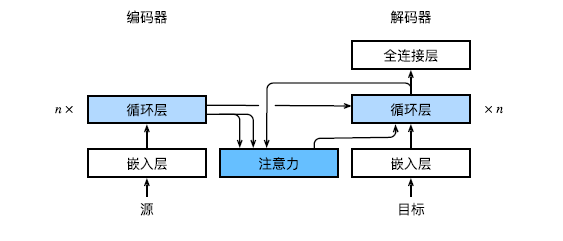

In [4]:
class Seq2SeqAttentionDecoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
    dropout=0, **kwargs):
    super().__init__(**kwargs)
    self.attention = AdditiveAttention(
                num_hiddens, num_hiddens, num_hiddens, dropout)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.GRU(embed_size + num_hiddens, 
                num_hiddens, num_layers,
                dropout=dropout)
    self.dense = nn.Linear(num_hiddens, vocab_size)

  def init_state(self, enc_outputs, enc_valid_lens, *args):
    # outputs的形状为(batch_size，num_steps，num_hiddens).
    # hidden_state的形状为(num_layers，batch_size，num_hiddens)
    outputs, hidden_state = enc_outputs
    return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
  
  def forward(self, X, state):
    # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
    # hidden_state的形状为(num_layers,batch_size,
    # num_hiddens)
    enc_outputs, hidden_state, enc_valid_lens = state
    # 输出X的形状为(num_steps,batch_size,embed_size)
    X = self.embedding(X).permute(1, 0, 2)
    outputs, self._attention_weights = [], []
    for x in X:
      # query的形状为(batch_size,1,num_hiddens)
      query = torch.unsqueeze(hidden_state[-1], dim=1)
      # context的形状为(batch_size,1,num_hiddens)
      context = self.attention(
      query, enc_outputs, enc_outputs, enc_valid_lens)
      # 在特征维度上连结
      x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
      # 将x变形为(1,batch_size,embed_size+num_hiddens)
      out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
      outputs.append(out)
      self._attention_weights.append(self.attention.attention_weights)
    # 全连接层变换后，outputs的形状为
    # (num_steps,batch_size,vocab_size)
    outputs = self.dense(torch.cat(outputs, dim=0))
    return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                        enc_valid_lens]

  @property
  def attention_weights(self):
    return self._attention_weights             

In [5]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long) # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

In [6]:
# 1. 载入数据集
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

# 2. 定义网络
encoder = Seq2SeqEncoder(
        len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
        len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)

In [7]:
# 3.初始化weight
def xavier_init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)
  if type(m) == nn.GRU:
    for param in m._flat_weights_names:
      if "weight" in param:
        nn.init.xavier_uniform_(m._parameters[param])

net.apply(xavier_init_weights)

# 4.定义losss和optimizer
loss = MaskedSoftmaxCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)

epoch: 50, loss:0.272235
epoch: 100, loss:0.128784
epoch: 150, loss:0.095491
epoch: 200, loss:0.089054
epoch: 250, loss:0.085297
epoch: 300, loss:0.081428
epoch: 350, loss:0.076888
epoch: 400, loss:0.079170
epoch: 450, loss:0.076665
epoch: 500, loss:0.080568


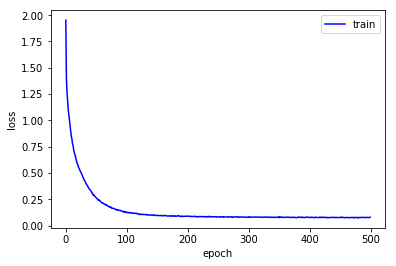

CPU times: user 2min 3s, sys: 3.21 s, total: 2min 6s
Wall time: 2min 10s


In [8]:
%%time
train_seq2seq(net, 500, train_iter, loss, optimizer, tgt_vocab)

In [9]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
            net, eng, src_vocab, tgt_vocab, num_steps)
    print(f'{eng} => pred: {translation} => true: {fra}, bleu {bleu(translation, fra, k=2):.3f}')

go . => pred: va ! => true: va !, bleu 1.000
i lost . => pred: j'ai perdu . => true: j'ai perdu ., bleu 1.000
he's calm . => pred: il est paresseux . => true: il est calme ., bleu 0.658
i'm home . => pred: je suis chez moi . => true: je suis chez moi ., bleu 1.000
